# Homework 1: An Ultrasound Problem

> Spencer Pease  
> AMATH 482  

# Abstract

_In this problem set we explore one use case where signal averaging and filtering can be used to extract information from a noisy data signal. Specifically, Fourier transforms are used to convert a signal to the frequency domain, where it is averaged over time filtered with a Gaussian function to remove noise. Targeting the predominant remaining frequency, we are able to track an object's path through a noisy field, determining its location at a given point in time._

# Introduction and Overview

Suppose your dog Fluffy has swallowed a marble, which now resides in the intestines. An ultrasound is used to obtain data showing the spatial variations in a small area of the intestines where the marble is. Due to Fluffy's movement, however,  sloshing fluids in the intestine add a lot of noise to the data. In order to save your dog, we must locate and compute the trajectory of the marble.

Since the noise is generated from the random movements of fluid, we can assume their corresponding frequencies in the ultrasound data will also be random. Therefore, by averaging the frequency-domain data, all random frequencies should diminish, leaving only the frequencies produced by the marble. An attenuation filter can then be applied to the data, centered around this target frequency, to further isolate the desired signal. Lastly, the frequency data can be converted back into the time domain to get a much clearer view of the spatial movements of just the marble.

# Theoretical Background

To accomplish these tasks, we will rely on two primary concepts: the _Fourier Transform_ and _Gaussian filtering_.

## The Fourier Transform (and FFT)

At a high level, the _Fourier Transform_ is used to decompose a time signal into its frequency components, represented as a discrete sum of _sines_ and _cosines_. Given a function $f(x)$, it integrates the function multiplied by _Euler's formula_ over an infinite domain, producing a function of frequency $F(k)$.

$$F(k) = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-ikx}f(x) dx$$  

There also exists an _Inverse Fourier Transform_, which converts a signal from the frequency domain back into the time domain:


$$f(x) = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{ikx}F(k) dk$$

This linearity is what makes the _Fourier Transform_ so useful in this context. Since we can move between the time and frequency domains, we can do our analysis in whatever space is most convenient, then return to the other space to get our results.


Computationally, we perform _Fourier Transforms_ using the _Fast Fourier Transform (FFT)_ algorithm, which was designed by some clever people to do exactly as its name suggests. Not only is it fast, it is significantly more accurate than other numerical methods of integration. These optimizations assume certain conditions exist. One is that the it operates over a discrete interval of $-2\pi$ to $2\pi$, meaning we must scale data from its original domain to fit this. Periodic boundary conditions are also assumed, and so we must set up our boundaries as such, even if our problem is not periodic. Another assumption is that the signal is described in $n = 2^{j}$ points. This is due to the recursive nature of _FFT_ which continually divides the signal in half.


## Gaussian Filtering

One method of removing noise from a signal data is to remove data not near a desired frequency. By multiplying our frequency-domain signal by some other function that is near zero for all values except our desired frequency, we can attenuate our signal, leaving only relevant data. One common function used to accomplish this is the _Gaussian function_: 

$$e^{-\tau (K - k_{0})^{2}}$$

A _Gaussian_ is centered around a given frequency $k_{0}$ where it has a normalized value of $1$, and decays to $0$ when moving away from the center. The rate of attenuation is controlled by $\tau$. 

The simplicity and smoothness of the _Gaussian function_ is why it's used to filter frequency-domain signals. Step-wise functions are hard to represent as _sines_ and _cosines_, whereas  for a _Gaussian_ it's simple.


# Algorithm Implementation and Development

The method tracking the trajectory of the marble is broken down into consecutive steps, described below. This particular implementation is done in _python_.

## Setup

Before our algorithm is implemented, several packages must be imported, and the ultrasound data must be loaded into the environment.

In [1]:
import numpy as np
from numpy.fft import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.io import loadmat

%matplotlib inline

In [2]:
# load data
testData = loadmat('../data/Testdata.mat')
Undata = testData['Undata']

t_steps = Undata.shape[0]

# Reshape our input data to be a 4D array (ie, a 3D space presented at multiple points in time) 
Un = np.ravel(Undata).reshape((n, n, n, t_steps), order = "F")

## Define the Domain

Our problem is defined over the $x, y, z$ intervals $-15$ to $15$ in the time domain, which we divide up into a 3D grid $64$ points across along every axis, allowing us to use _FFT_. We then transform our time domain interval into the frequency domain interval by scaling by $\frac{2\pi}{2L}$, giving us the needed interval of $-2\pi$ to $2\pi$. We also swap the first and second halves of the frequency domain, as _FFT_ swaps the first and second half of its input signal.

In [3]:
L = 15 # spatial domain
n = 64 # Fourier modes

x = np.linspace(-L, L, n+1)[0:n]; y = x; z = x
k = (2*np.pi / (2*L)) * np.append(np.arange(0, n/2), np.arange(-n/2, 0))
ks = fftshift(k)

X, Y, Z = np.meshgrid(x, y, z)
Kx, Ky, Kz = np.meshgrid(ks, ks, ks)

## Average the Spectrum

> Steps:
>  - Apply Fourier Transform (FFT)  
>  - Average the spectrum over time  
>  - Normalize by largest value  
 
In order to determine the center frequency for our filter, we must remove some of the noise from our signal. By transforming our data to the frequency domain using `fftn` for each time step, we get a composite of all the frequencies of our signal across time. Since we know some of these frequencies to be random, averaging the spectrum over time will make all the random data less intense, leaving only the frequencies corresponding to the marble. We can also normalize our data get everything on a scale of $0$ to $1$.

In [5]:
Unt = fftn(Un, axes = (0,1,2))
Unt_ave = np.abs(fftshift(Unt.sum(axis = 3))) / t_steps
Unt_norm = Unt_ave / np.amax(Unt_ave)

## Determine the Center Frequency

> Steps:  
>  - Find the indices (in Fourier space) of the largest value (aka the target frequency location)  

Now that we have our averaged and normalized spectral frequencies, we need to decide what our target frequency in the data is. The frequencies most associated with the marble will make up the largest portion of the time-averaged signal, so we can simply search for the maximum value and its indices.

In [56]:
max_ind = np.unravel_index(Unt_norm.argmax(), Unt_norm.shape)

kx0 = Kx[max_ind]
ky0 = Ky[max_ind]
kz0 = Kz[max_ind]

print("kx0: {0:.3f},  ky0: {1:.3f},  kz0: {2:.3f}".format(kx0, ky0, kz0))

kx0: 1.885,  ky0: -1.047,  kz0: 0.000


## Filter the Data

> Steps:  
>  - create filter around target frequency 
>  - Filter the data around the center frequency in order to denoise the data

Now that we have the position of our target frequency  in Fourier space, we can construct a 3D _Gaussian_ centered around that frequency to use as a filter. We can then multiply this function by our Fourier-transformed data at every point in time to filter out all the noise generated from random variation. It's important to note that we must use `fftshift` to unswap the first and second halve of our domains for our data, as the _Gaussian_ filter is constructed as if there was no swapping.

In [57]:
tau = .5
gFilter = np.exp(-tau*((Kx - kx0)**2 + (Ky - ky0)**2 + (Kz - kz0)**2))

In [58]:
Unft = fftshift(Unt) * np.expand_dims(gFilter, axis = 3)

## Return to the Time Domain

> Steps:  
>  - Convert back to the time domain  

Finally, we can convert our filtered data back to the time domain with `ifftn`. Now we have data showing spatial variations of only the non-random marble.

In [59]:
Unf = np.abs(ifftn(fftshift(Unft), axes = (0,1,2)))

# Computational Results

Using our newly denoised time-domain spatial data, we can track the movement of the marble by looking for the location of the highest intensity signal at each time step, and saving them to a list of coordinates we can plot.

In [60]:
marble_loc = np.zeros((t_steps, 3))

for j in range(t_steps):
    marble_ind = np.unravel_index(Unf[:,:,:,j].argmax(), (n,n,n))
    marble_loc[j,:] = [X[marble_ind], Y[marble_ind], Z[marble_ind]]

In [65]:
# location of the marble at the final time step
final_loc = marble_loc[t_steps - 1,:]
print("x = {0:.3f},  y = {1:.3f},  z = {2:.3f}".format(final_loc[0], final_loc[1], final_loc[2]))

x = -5.625,  y = 4.219,  z = -6.094


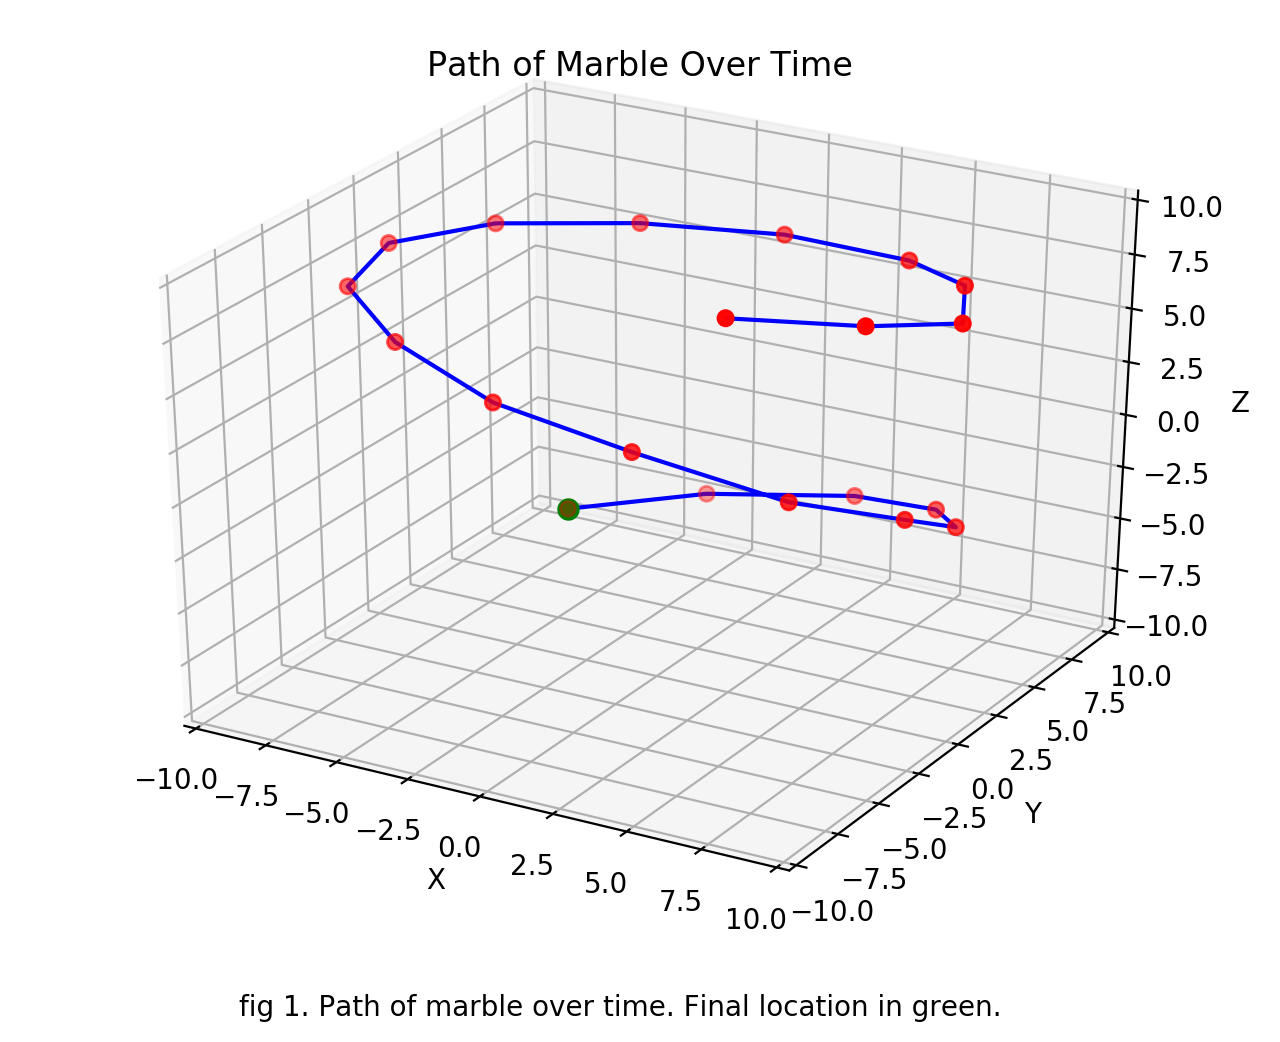

In [69]:
txt = "fig 1. Path of marble over time. Final location in green."

fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot(marble_loc[:,0], marble_loc[:,1], marble_loc[:,2], color='b')
ax.scatter(marble_loc[:,0], marble_loc[:,1], marble_loc[:,2], color='r', s = 30)
ax.scatter(marble_loc[19,0], marble_loc[19,1], marble_loc[19,2], color='g', s = 50)

ax.set_title("Path of Marble Over Time")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
fig.text(.5, .05, txt, ha='center')

plt.show()


# Summary and Conclusions

In conclusion, the vet should focus an acoustic wave at the coordinates in order to break up the marble located in Fluffy's intestines:

$$(x, y, z) = (-5.625, 4.219, -6.094)$$ 

We were able to determine this by using _Fourier Transforms_, _Gaussian filtering_, and time-averaging to extract relevant data from a noisy dataset.

# Appendix A - Function Descriptions

- `fftn`: Fast Fourier transform in n-dimensions
- `ifftn`: Inverse Fast Fourier transform in n-dimensions
- `fftshift`: Swap first and second halves of domain, as is done in FFT
- `np.exp`: expodential $e$
- `np.abs`: absolute value
- `np.amax`: find maximum value in array
- `np.argmax`: find indices of maximum value in array
- `np.linespace`: create a linearly spaced array